### Importation packages

In [28]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV

In [29]:
# importation data
kidney = pd.read_csv("data/kidney.csv")
housevotes = pd.read_csv("data/housevotesNA.csv", na_values=['?'])

### KIDNEY DATA

In [30]:
kidney_head = kidney.head(5)
kidney_head.to_latex('tables_latex/kidney_head.tex')
kidney_head

,age,bp,sg,al,su,pc,pcc,ba,bgr,bu,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,70,1.005,4,0,abnormal,present,notpresent,117,56,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
1,53,90,1.020,2,0,abnormal,present,notpresent,70,107,...,29,12100,3.7,yes,yes,no,poor,no,yes,ckd
2,63,70,1.010,3,0,abnormal,present,notpresent,380,60,...,32,4500,3.8,yes,yes,no,poor,yes,no,ckd
3,68,70,1.015,3,1,normal,present,notpresent,208,72,...,28,12200,3.4,yes,yes,yes,poor,yes,no,ckd
4,68,80,1.010,3,2,abnormal,present,present,157,90,...,16,11000,2.6,yes,yes,yes,poor,yes,no,ckd


notckd    115
ckd        74
Name: class, dtype: int64


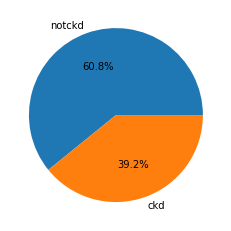

In [31]:
print(pd.value_counts(kidney['class']))
labels = ['notckd', 'ckd']
sizes = [115, 74]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.savefig('graphes/kidney_class.pdf', dpi=600)
plt.show()

In [32]:
kidney.dtypes

age        int64
bp         int64
sg       float64
al         int64
su         int64
pc        object
pcc       object
ba        object
bgr        int64
bu         int64
sc       float64
sod        int64
pot      float64
hemo     float64
pcv        int64
wbcc       int64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class     object
dtype: object

In [33]:
kidney.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc',
       'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [34]:
# Proportion des missing values
kidney.isna().sum() / kidney.shape[0]

age      0.0
bp       0.0
sg       0.0
al       0.0
su       0.0
pc       0.0
pcc      0.0
ba       0.0
bgr      0.0
bu       0.0
sc       0.0
sod      0.0
pot      0.0
hemo     0.0
pcv      0.0
wbcc     0.0
rbcc     0.0
htn      0.0
dm       0.0
cad      0.0
appet    0.0
pe       0.0
ane      0.0
class    0.0
dtype: float64

### Transformation des variables categorielles

In [35]:
df_cat = kidney.select_dtypes(include='object').drop(['class'], axis=1)
df_num = kidney.select_dtypes(exclude='object')
cat_vars = df_cat.columns
num_vars = df_num.columns

In [36]:
def encoder_varqual(varlist, df):
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    for var in varlist:
        df[var] = encoder.fit_transform(df[var])
    return df  

In [37]:
varlist = ['pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']
kidney = encoder_varqual(varlist, kidney)

In [38]:
kidney.head(5)

,age,bp,sg,al,su,pc,pcc,ba,bgr,bu,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,70,1.005,4,0,0,1,0,117,56,...,32,6700,3.9,1,0,0,1,1,1,0
1,53,90,1.020,2,0,0,1,0,70,107,...,29,12100,3.7,1,1,0,1,0,1,0
2,63,70,1.010,3,0,0,1,0,380,60,...,32,4500,3.8,1,1,0,1,1,0,0
3,68,70,1.015,3,1,1,1,0,208,72,...,28,12200,3.4,1,1,1,1,1,0,0
4,68,80,1.010,3,2,0,1,1,157,90,...,16,11000,2.6,1,1,1,1,1,0,0


### Rapport de correlations : quantitative et qualitative variables

In [39]:
def rapport_corr(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [40]:
def Fisher_test(df, num_vars, target):
    
    Fisher = pd.DataFrame()
    Fisher["Variables"] = num_vars
    Fisher["Fisher"] = [np.round(rapport_corr(df[target], df[var]) * (df.shape[0]-2) / (1-rapport_corr(df[target], df[var])), 
                        decimals=2) for var in num_vars]
    
    return Fisher

In [41]:
Fisher = Fisher_test(kidney, num_vars, 'class')
kidney_Fisher = Fisher.sort_values(['Fisher'],ascending=0)
kidney_Fisher.to_latex('tables_latex/kidney_Fisher.tex', index=False)
kidney_Fisher

,Variables,Fisher
10,hemo,363.49
11,pcv,362.36
2,sg,272.41
3,al,253.46
13,rbcc,189.74
7,sc,98.07
8,sod,85.78
6,bu,81.68
5,bgr,67.14
4,su,47.80


### Test de chi2: qualitatives variables

In [42]:
def test_chi2(df, cat_vars, target):

    from scipy.stats import chi2_contingency
    from scipy.stats import chi2
    
    for var in cat_vars:
        crosstab = pd.crosstab(index=df[target],columns=df[var])
        stat, p, dof, expected = chi2_contingency(crosstab)
        stats.append(np.round(stat, decimals=2)) 
        pvalue.append(np.round(p, decimals=2))

        prob = 0.99
        critical = chi2.ppf(prob, dof)
        criticals.append(np.round(critical, decimals=2))

In [43]:
stats=[]
pvalue=[]
criticals=[]
    
test_chi2(kidney, cat_vars, 'class')
corr_chi2 = pd.DataFrame()

corr_chi2['variables'] = cat_vars
corr_chi2['stats'] = stats
corr_chi2['pvalue'] = pvalue
corr_chi2['criticals'] = criticals
kidney_chi2 = corr_chi2.sort_values(by='stats', ascending=False)
kidney_chi2.to_latex('tables_latex/kidney_chi2.tex', index=False)
kidney_chi2

,variables,stats,pvalue,criticals
3,htn,120.07,0.0,6.63
4,dm,96.59,0.0,6.63
0,pc,63.66,0.0,6.63
6,appet,46.02,0.0,6.63
7,pe,43.94,0.0,6.63
8,ane,33.90,0.0,6.63
1,pcc,28.16,0.0,6.63
5,cad,24.45,0.0,6.63
2,ba,19.04,0.0,6.63


### Calcul VIF

In [44]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = kidney.drop(['class','pot'], axis=1)
X['target'] = kidney['class']
xprime = X.drop(['target'], axis=1)
features = xprime.columns
feature = "+".join(features)

# Regression multiple de X sur y:
y, X = dmatrices('target ~' + feature, X, return_type='dataframe')

vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF Factor"] = [np.round(variance_inflation_factor(X.values, i), decimals=4) for i in range(X.shape[1])]
kidney_vif = vif.sort_values(['VIF Factor'], ascending=False)
kidney_vif.to_latex('tables_latex/kidney_vif.tex', index=False)
kidney_vif

,variables,VIF Factor
0,Intercept,82783.7912
13,hemo,5.7880
14,pcv,5.6128
11,sc,4.7766
17,htn,4.6965
10,bu,4.4951
4,al,4.0704
9,bgr,3.6284
5,su,3.4614
18,dm,3.4578


In [45]:
kidney[num_vars].describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,51.470899,75.079365,1.019048,0.841270,0.343915,138.941799,53.142857,2.264550,138.629630,4.598413,13.300529,40.634921,8544.444444,4.766667
std,15.742457,11.514055,0.005639,1.386174,0.952727,75.394013,45.663032,2.969107,7.008382,3.189285,2.848208,9.046514,2978.939075,1.008264
min,6.000000,50.000000,1.005000,0.000000,0.000000,70.000000,10.000000,0.400000,111.000000,2.500000,3.100000,9.000000,3800.000000,2.100000
25%,42.000000,70.000000,1.015000,0.000000,0.000000,97.000000,27.000000,0.800000,135.000000,3.800000,11.300000,34.000000,6700.000000,4.000000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,117.000000,40.000000,1.100000,139.000000,4.500000,13.900000,42.000000,8000.000000,4.800000
75%,63.000000,80.000000,1.025000,2.000000,0.000000,134.000000,51.000000,2.200000,143.000000,4.900000,15.500000,48.000000,9800.000000,5.500000
max,90.000000,110.000000,1.025000,4.000000,5.000000,490.000000,309.000000,15.200000,150.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


# HOUSE VOTES

In [56]:
cat_vars = housevotes.columns 
housevotes.head(5)

,class,hand,water,adoption,physician,salvador,religious,satellite,nicaraguan,missile,immigration,synfuels,education,superfund,crime,exports,administration
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [57]:
# Proportion des missing values
housevotes.isna().sum() / housevotes.shape[0]

class             0.000000
hand              0.027586
water             0.110345
adoption          0.025287
physician         0.025287
salvador          0.034483
religious         0.025287
satellite         0.032184
nicaraguan        0.034483
missile           0.050575
immigration       0.016092
synfuels          0.048276
education         0.071264
superfund         0.057471
crime             0.039080
exports           0.064368
administration    0.239080
dtype: float64

In [58]:
housevotes.dtypes

class             object
hand              object
water             object
adoption          object
physician         object
salvador          object
religious         object
satellite         object
nicaraguan        object
missile           object
immigration       object
synfuels          object
education         object
superfund         object
crime             object
exports           object
administration    object
dtype: object

## Imputation data

In [59]:
from sklearn.impute import SimpleImputer
impute = SimpleImputer(strategy="most_frequent")
housevotes = pd.DataFrame(impute.fit_transform(housevotes))
housevotes.columns  = cat_vars
housevotes_head = housevotes.head(5)

housevotes.to_csv("data/housevotes.csv", index=False)

housevotes_head.to_latex('tables_latex/housevotes_head.tex', index=False)
housevotes_head

,class,hand,water,adoption,physician,salvador,religious,satellite,nicaraguan,missile,immigration,synfuels,education,superfund,crime,exports,administration
0,republican,n,y,n,y,y,y,n,n,n,y,n,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,y
2,democrat,n,y,y,n,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,y,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,n,y,y,y,y


democrat      267
republican    168
Name: class, dtype: int64


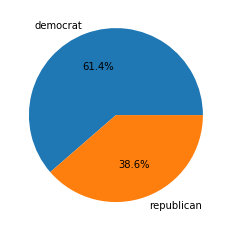

In [60]:
print(pd.value_counts(housevotes['class']))
labels = ['democrat', 'republican']
sizes = [267, 168]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.savefig('graphes/housevotes_class.pdf', dpi=600)
plt.show()

### Transformation des variables categorielles

In [61]:
housevotes = encoder_varqual(cat_vars, housevotes)
housevotes.head(5)

,class,hand,water,adoption,physician,salvador,religious,satellite,nicaraguan,missile,immigration,synfuels,education,superfund,crime,exports,administration
0,1,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0,1
1,1,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1
2,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,0,0
3,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,1
4,0,1,1,1,0,1,1,0,0,0,0,1,0,1,1,1,1


### Test de chi2: qualitatives variables

In [62]:
cat_vars = housevotes.drop(['class'], axis=1).columns
stats=[]
pvalue=[]
criticals=[]
    
test_chi2(housevotes, cat_vars, 'class')
corr_chi2 = pd.DataFrame()

corr_chi2['variables'] = cat_vars
corr_chi2['stats'] = stats
corr_chi2['pvalue'] = pvalue
corr_chi2['criticals'] = criticals

housevotes_chi2 = corr_chi2.sort_values(by='stats', ascending=False)
housevotes_chi2.to_latex('tables_latex/housevotes_chi2.tex', index=False)
housevotes_chi2

,variables,stats,pvalue,criticals
3,physician,356.14,0.0,6.63
2,adoption,231.45,0.0,6.63
4,salvador,200.53,0.0,6.63
11,education,190.50,0.0,6.63
8,missile,169.15,0.0,6.63
7,nicaraguan,163.05,0.0,6.63
13,crime,157.36,0.0,6.63
12,superfund,118.57,0.0,6.63
14,exports,112.22,0.0,6.63
6,satellite,108.63,0.0,6.63


### Calcul VIF

In [63]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = housevotes.drop(['class', 'immigration','water'], axis=1)
X['target'] = housevotes['class']
xprime = X.drop(['target'], axis=1)
features = xprime.columns
feature = "+".join(features)

# Regression multiple de X sur y:
y, X = dmatrices('target ~' + feature, X, return_type='dataframe')

vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF Factor"] = [np.round(variance_inflation_factor(X.values, i), decimals=2) for i in range(X.shape[1])]
housevotes_vif = vif.sort_values(['VIF Factor'], ascending=False)

housevotes_vif.to_latex('tables_latex/housevotes_vif.tex', index=False)
housevotes_vif

,variables,VIF Factor
0,Intercept,35.86
4,salvador,4.42
7,nicaraguan,3.58
3,physician,3.57
8,missile,3.00
2,adoption,2.70
6,satellite,2.43
12,crime,2.34
10,education,2.25
5,religious,2.05


In [64]:
# Les occurences uniques pour chaque variables
housevotes.nunique()

class             2
hand              2
water             2
adoption          2
physician         2
salvador          2
religious         2
satellite         2
nicaraguan        2
missile           2
immigration       2
synfuels          2
education         2
superfund         2
crime             2
exports           2
administration    2
dtype: int64